# Title
Info

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
# sns.set(context='paper', style='white', font='CMU Serif', rc={'axes.labelpad':0, 'axes.linewidth': 0.5})
sns.set(context='paper', style='whitegrid', font='CMU Serif', rc={'axes.labelpad':0, 'axes.linewidth': 0.5})
sns.set_context("notebook", rc={"grid.linewidth": 0.5})

In [141]:
class Inputs():
    def __init__(self, deltaP, maxSamples, seed=0):
        self.deltaP = deltaP
        self.maxSamples = maxSamples
        self.winning = None
        self.pA = None
        self.pB = None
        self.As = []
        self.Bs = []
        self.rng = np.random.RandomState(seed=seed)
    def set_AB(self):
        self.winning = "A" if self.rng.rand()<0.5 else "B"
        highs = np.arange(0.1+self.deltaP, 0.9, 0.1)
        high = highs[self.rng.randint(len(highs))]
        low = high - self.deltaP
        if self.winning=="A":
            self.pA = high
            self.pB = low
        else:
            self.pB = high
            self.pA = low
        self.As = self.rng.binomial(1, self.pA, self.maxSamples)
        self.Bs = self.rng.binomial(1, self.pB, self.maxSamples)
        self.As[np.where(self.As==0)[0]] = -1
        self.Bs[np.where(self.Bs==0)[0]] = -1
    def get_AB(self, t):
        AB = [self.As[int(t)], self.Bs[int(t)]] if t<self.maxSamples else [0,0]
        AB = [AB[0], 0] if t%1.0<0.5 else [0, AB[1]]  # A presented for 500ms, then B presented for 500ms
        return AB

In [213]:
def build_network(inputs, nNeurons=500, tau=0.1, seed=0, maxSamples=12,
        w_time_elapsed=0.5, w_ramp_rate=2, w_delta_evidence=0, decision_threshold=0.4, starting_evidence=0):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    
    func_time_elapsed = lambda t: decision_threshold * (1 - w_time_elapsed * t/maxSamples)
    func_ramp = lambda x: tau * w_ramp_rate/maxSamples * x
    func_uncertainty = lambda x: w_delta_evidence * np.abs(x[0]-x[1])

    with net:
        # Inputs
        AB = nengo.Node(lambda t, x: inputs.get_AB(t), size_in=2)
        time_elapsed = nengo.Node(lambda t: t)
        start_accumulate = nengo.Node(lambda t: starting_evidence if t<1 else 0)
        bias_BG = nengo.Node(0.5)
        
        # Ensembles
        value = nengo.networks.EnsembleArray(nNeurons, 2)
        accumulate = nengo.networks.EnsembleArray(nNeurons, 2)
        diff = nengo.Ensemble(2*nNeurons, 2)
        BG = nengo.networks.BasalGanglia(2, nNeurons)
        gate = nengo.Ensemble(nNeurons, 1)
        action = nengo.networks.Thalamus(2, nNeurons, threshold=0.0, mutual_inhib=0)
        
        # Connections
        nengo.Connection(AB, value.input)
        nengo.Connection(time_elapsed, gate, function=func_time_elapsed)
        nengo.Connection(start_accumulate, accumulate.input, transform=[[1], [1]], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(accumulate.output, accumulate.input, synapse=tau)
        nengo.Connection(accumulate.output, BG.input)
        nengo.Connection(accumulate.output, diff)
        nengo.Connection(diff, gate, function=func_uncertainty)
        nengo.Connection(gate, BG.stn.input, transform=[[1], [1]])
        nengo.Connection(bias_BG, BG.input, transform=[[1], [1]])
        nengo.Connection(BG.output, action.input, transform=2)

        # Probes
        net.pAB = nengo.Probe(AB)
        net.pValue = nengo.Probe(value.output)
        net.pAccumulate = nengo.Probe(accumulate.output)
        net.pDiff = nengo.Probe(diff)
        net.pGate = nengo.Probe(gate)
        net.pBG = nengo.Probe(BG.output)
        net.pAction = nengo.Probe(action.output)
        
        # references
        net.ramp_rate = w_ramp_rate/maxSamples
        
    return net

In [214]:
def is_correct(inputs, net, sim, dt=0.001, action_threshold=0.05):
    chooseA = np.argwhere(sim.data[net.pAction][:,0] > action_threshold)
    chooseB = np.argwhere(sim.data[net.pAction][:,1] > action_threshold)
    timeA = chooseA[0][0]*dt if len(chooseA)>0 else sim.trange()[-1]
    timeB = chooseB[0][0]*dt if len(chooseB)>0 else sim.trange()[-1]
    if inputs.winning=="A":
        if timeA == timeB:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][0] > sim.data[net.pAccumulate][-1][1] else False
            time = timeA
        elif timeA < timeB:
            correct = True
            time = timeA
        elif timeB < timeA:
            correct = False
            time = timeB
    elif inputs.winning=="B":
        if timeB == timeA:  # forced response
            correct = True if sim.data[net.pAccumulate][-1][1] > sim.data[net.pAccumulate][-1][0] else False
            time = timeB
        elif timeB < timeA:
            correct = True
            time = timeB
        elif timeA < timeB:
            correct = False
            time = timeA
    return correct, int(np.ceil(time))

In [215]:
def run_once(deltaP, maxSamples, seed, dt=0.001):
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    inputs.set_AB()
    net = build_network(inputs, seed=seed, maxSamples=maxSamples)
    sim = nengo.Simulator(net, progress_bar=False)
    with sim:
        sim.run(maxSamples, progress_bar=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=((6.38, 3)))
    idealA = np.cumsum(sim.data[net.pAB][:,0]) * net.ramp_rate * dt
    idealB = np.cumsum(sim.data[net.pAB][:,1]) * net.ramp_rate * dt
    ax.plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
    ax.plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
    ax.plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
    ax.plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
    ax.plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0])
    ax.plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1])
    ax.plot(sim.trange(), sim.data[net.pGate], label='gate', color='k')
    correct, cues = is_correct(inputs, net, sim)
    title = f"{'correct' if correct else 'incorrect'}, cues={cues:.0f}"
    ax.set(xlabel="time (s)", ylabel=r"$\mathbf{x}(t)$", title=title, xticks=np.arange(0, maxSamples, 1))
#     fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((6.38, 4)))
#     idealA = np.cumsum(sim.data[net.pAB][:,0]) * net.ramp_rate * dt
#     idealB = np.cumsum(sim.data[net.pAB][:,1]) * net.ramp_rate * dt
#     axes[0].plot(sim.trange(), idealA, label="ideal A", linestyle="--", color=palette[0])
#     axes[0].plot(sim.trange(), idealB, label="ideal B", linestyle="--", color=palette[1])
#     axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,0], label="evidence A", color=palette[0])
#     axes[0].plot(sim.trange(), sim.data[net.pAccumulate][:,1], label="evidence B", color=palette[1])
#     axes[1].plot(sim.trange(), sim.data[net.pGate], label='gate', color='k')
#     axes[1].plot(sim.trange(), sim.data[net.pBG][:,0], label="BG A", color=palette[0])
#     axes[1].plot(sim.trange(), sim.data[net.pBG][:,1], label="BG B", color=palette[1])
#     axes[1].plot(sim.trange(), sim.data[net.pAction][:,0], label="choose A", alpha=0.3, color=palette[0])
#     axes[1].plot(sim.trange(), sim.data[net.pAction][:,1], label="choose B", alpha=0.3, color=palette[1])
#     axes[0].set(ylabel=r"$\mathbf{x}(t)$")
#     axes[1].set(xlabel="time (s)", ylabel=r"$\mathbf{x}(t)$")
#     axes[0].legend(loc='upper left')
#     axes[1].legend(loc='upper left')

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

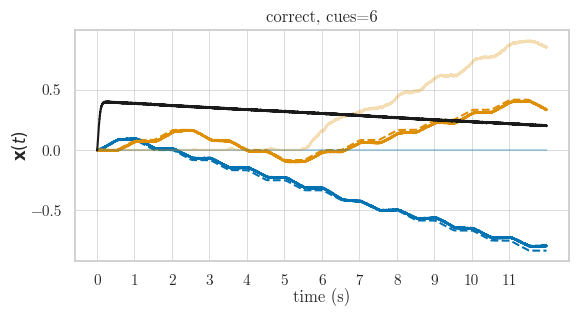

In [216]:
run_once(deltaP=0.4, maxSamples=12, seed=3)

In [217]:
def run_trials(nTrials, deltaP, maxSamples, seed, dt=0.001):
    dfs = []
    columns = ('seed', 'trial', 'correct', 'cues')
    inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=seed)
    for n in range(nTrials):
        print(f"trial {n}")
        inputs.set_AB()
        net = build_network(inputs, seed=seed)
        sim = nengo.Simulator(net, progress_bar=False)
        with sim:
            sim.run(maxSamples, progress_bar=False)
        correct, cues = is_correct(inputs, net, sim)
        dfs.append(pd.DataFrame([[seed, n, correct, cues]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return(data)

In [218]:
data = run_trials(nTrials=10, deltaP=0.4, maxSamples=12, seed=0)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9


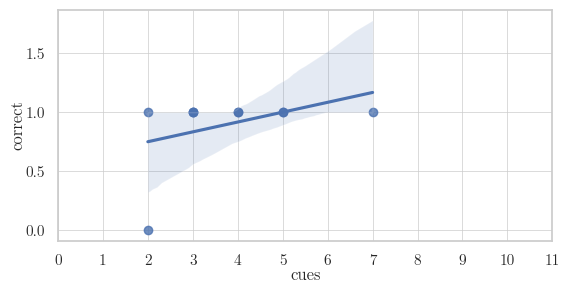

In [219]:
fig, ax = plt.subplots(figsize=((6.38, 3)))
sns.regplot(data=data, x="cues", y="correct", ax=ax)
ax.set(xticks=np.arange(0, 12, 1))
plt.show()

In [226]:
def scan_parameter(scan, nNetworks, nTrials, deltaP, maxSamples, dt=0.001, low=0.2, high=0.5):
    dfs = []
    columns = ('scan', 'param', 'seed', 'trial', 'correct', 'cues')
    rng = np.random.RandomState(seed=nNetworks)
    for s in range(nNetworks):
        print(f"seed {s}")
        inputs = Inputs(deltaP=deltaP, maxSamples=maxSamples, seed=s)
        param = rng.uniform(low, high)
        for n in range(nTrials):
            print(f"trial {n}")
            inputs.set_AB()
            if scan=="decision threshold":
                net = build_network(inputs, seed=s, decision_threshold=param)
            else:
                raise
            sim = nengo.Simulator(net, progress_bar=False)
            with sim:
                sim.run(maxSamples, progress_bar=False)
            correct, cues = is_correct(inputs, net, sim)
            dfs.append(pd.DataFrame([[scan, param, s, n, correct, cues]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    return(data)

In [265]:
def collapse_scan(data, scan):
    dfs = []
    columns = ('scan', 'param', 'seed', 'mean correct', 'mean cues')
    for s in range(data['seed'].max()+1):
        d = data.query("seed==@s")
        dfs.append(pd.DataFrame([[scan, d['param'].mean(), s, d['correct'].mean(), d['cues'].mean()]], columns=columns))
    collapsed_data = pd.concat(dfs, ignore_index=True)
    return collapsed_data

In [268]:
data = scan_parameter(scan="decision threshold", nNetworks=3, nTrials=20, deltaP=0.4, maxSamples=12)

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19


                 scan     param  seed  mean correct  mean cues
0  decision threshold  0.365239     0          0.95       3.95
1  decision threshold  0.412444     1          1.00       4.40
2  decision threshold  0.287271     2          1.00       3.45


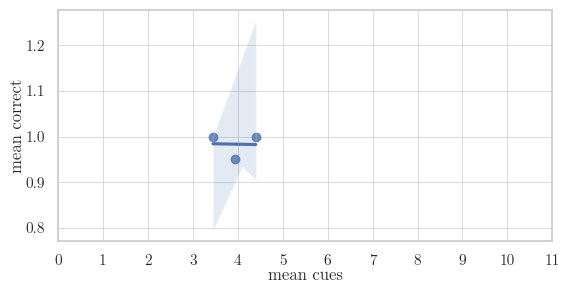

In [273]:
collapsed_data = collapse_scan(data, "decision threshold")
print(collapsed_data)

fig, ax = plt.subplots(figsize=((6.38, 3)))
sns.regplot(data=collapsed_data, x="mean cues", y="mean correct", ax=ax)
ax.set(xticks=np.arange(0, 12, 1))
plt.show()